# Predicting Survival in Patients with Liver Cirrhosis
This project focuses on predicting the survival status of patients diagnosed with liver cirrhosis using machine learning models. The dataset includes clinical and laboratory features from patients, with the target variable being the survival status categorized as **'C', 'D',** or **'CL'**. 

### Objectives
1. Preprocess the training and test datasets by handling missing values, encoding categorical features, and addressing class imbalance.
2. Build and evaluate three machine learning models: Logistic Regression, Random Forest, and Support Vector Machine (SVM).
3. Use the best-performing model to generate predictions on the test dataset.

The project makes use of techniques such as SMOTE for class imbalance correction and employs a systematic evaluation to identify the most effective model for the task.


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

## Step 1: Load and Explore the Datasets
The training and test datasets were loaded and analyzed to understand their structure and any data quality issues.

### Dataset Overview
- **Training Data:** 224 samples, 19 features (including 'Status')
- **Test Data:** 88 samples, 18 features (excluding 'Status')

### Missing Value Handling
Four numerical features with missing values were identified:
- Cholesterol
- Copper
- Tryglicerides
- Platelets

Missing values were imputed using the median of each feature to maintain consistency.

### Encoding Categorical Features
Categorical features such as 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', and 'Edema' were encoded using one-hot encoding. This conversion ensures that the machine learning models can effectively process these features.

### Label Distribution
The target variable ('Status') exhibited class imbalance:
- **C:** 130 samples
- **D:** 84 samples
- **CL:** 10 samples

This imbalance was addressed using SMOTE to generate synthetic samples for the minority classes, resulting in a balanced dataset.


In [2]:
train = pd.read_csv('5d_cirrhosis_train.csv')
test = pd.read_csv('5d_cirrhosis_test.csv')

#preserve testID and Status from test dataset
test_IDs = test['testID']
test_true_labels = test['Status'] if 'Status' in test.columns else None

#drop trainID from train data
train.drop('trainID', axis=1, inplace=True)

#concat train and test for preprocessing
data = pd.concat([train, test.drop(columns=['testID'])], sort=False)
print(f"Concat Data Dimensions: {data.shape}")

Concat Data Dimensions: (312, 19)


In [3]:
#numerical features w missing values
numerical_features = ['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']

#impute missing values with median of each feature
for feature in numerical_features:
    median_value = data[feature].median()
    data[feature] = data[feature].fillna(median_value)

#debug - print missing values remaining if any
missing_data = data.isnull().sum()
print("----- Missing Data Information -----")
for feature, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"Feature: {feature}, Missing Entries: {missing_count}")
print("-------------------------------------------------")

----- Missing Data Information -----
Feature: Status, Missing Entries: 88
-------------------------------------------------


In [4]:
#categorical features to be one-hot encoded
categorical_features_to_encode = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

#one-hot encode the categorical features
data_encoded = pd.get_dummies(data, columns=categorical_features_to_encode, drop_first=True)

In [5]:
#split data back into train and test set
train_encoded = data_encoded[data_encoded['Status'].notnull()]
test_encoded = data_encoded[data_encoded['Status'].isnull()].drop(columns=['Status'])

#extract features and target from train dataset
features_train = train_encoded.drop(columns=['Status'])
target_train = train_encoded['Status']

#only features for test dataset  (status is dropped)
features_test = test_encoded

Label Distribution in Training Data:
Status
C     119
D      93
CL     12
Name: count, dtype: int64


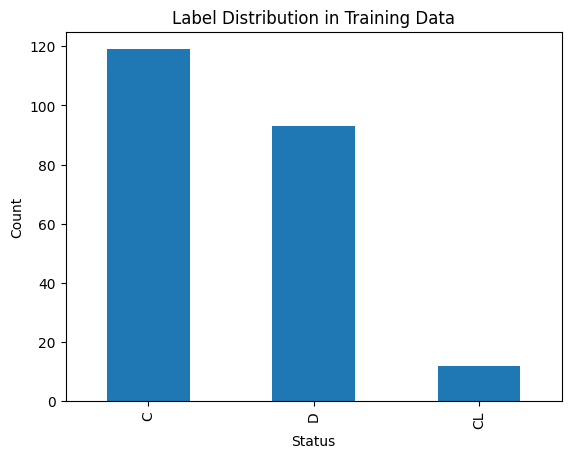

In [6]:
scaler = StandardScaler()
scaler.fit(features_train)  #fit only on train data

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

#label distribution in train data
label_distribution = train['Status'].value_counts()
print("Label Distribution in Training Data:")
print(label_distribution)

#plot distribution
label_distribution.plot(kind='bar', title='Label Distribution in Training Data', xlabel='Status', ylabel='Count')
plt.show()

Balanced Label Distribution in Training Data:
Status
D     119
CL    119
C     119
Name: count, dtype: int64


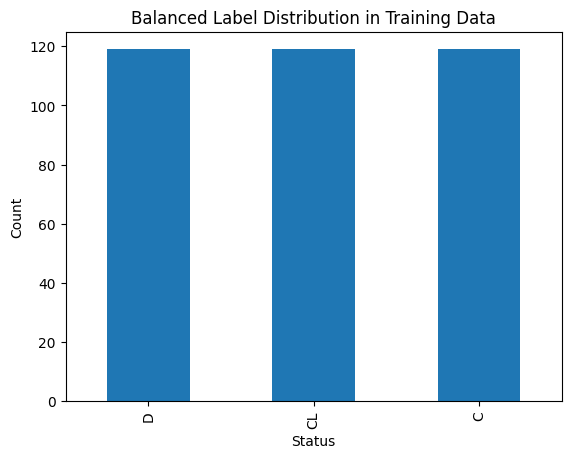

In [7]:
#balance dataset using SMOTE
smote = SMOTE(random_state=123)
features_train_balanced, target_train_balanced = smote.fit_resample(features_train_scaled, target_train)

#check new distribution of target
print("Balanced Label Distribution in Training Data:")
print(pd.Series(target_train_balanced).value_counts())

#plot balanced distribution
pd.Series(target_train_balanced).value_counts().plot(kind='bar', title='Balanced Label Distribution in Training Data', xlabel='Status', ylabel='Count')
plt.show()

## Step 2: Model Building and Evaluation
Three supervised learning models were developed to predict the survival status:

### Model Descriptions
1. **Logistic Regression**: A simple and interpretable baseline model.
2. **Random Forest**: A robust model that handles non-linear relationships and reduces overfitting by averaging multiple decision trees.
3. **Support Vector Machine (SVM)**: A powerful model suited for high-dimensional data with versatility in kernel selection.

### Handling Class Imbalance
To ensure fair training across all classes, SMOTE was applied to balance the dataset. This technique created synthetic samples for the minority class ('CL'), resulting in equal representation for all classes.

### Model Performance
Each model was trained and evaluated using a validation set. The results showed:
- **Random Forest** had the highest performance with 82% accuracy and strong recall for the minority class.
- Logistic Regression and SVM also performed well but were slightly less effective than Random Forest.

### Metric Selection
Evaluation was conducted using metrics like precision, recall, and F1-score to ensure a holistic assessment of model performance.


In [8]:
#split training data into train/validate sets
X_train, X_val, y_train, y_val = train_test_split(features_train_balanced, target_train_balanced, test_size=0.2, random_state=123)

logreg_model = LogisticRegression(max_iter=1000, random_state=123)
rf_model = RandomForestClassifier(random_state=123)
svm_model = SVC(random_state=123)

# Train and evaluate Logistic Regression
logreg_model.fit(X_train, y_train)
y_val_pred_logreg = logreg_model.predict(X_val)
print("Logistic Regression with SMOTE - Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred_logreg))

# Train and evaluate Random Forest
rf_model.fit(X_train, y_train)
y_val_pred_rf = rf_model.predict(X_val)
print("Random Forest with SMOTE - Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred_rf))

# Train and evaluate SVM
svm_model.fit(X_train, y_train)
y_val_pred_svm = svm_model.predict(X_val)
print("SVM with SMOTE - Validation Set Evaluation:")
print(classification_report(y_val, y_val_pred_svm))

Logistic Regression with SMOTE - Validation Set Evaluation:
              precision    recall  f1-score   support

           C       0.67      0.70      0.68        23
          CL       0.72      0.84      0.78        25
           D       0.89      0.71      0.79        24

    accuracy                           0.75        72
   macro avg       0.76      0.75      0.75        72
weighted avg       0.76      0.75      0.75        72

Random Forest with SMOTE - Validation Set Evaluation:
              precision    recall  f1-score   support

           C       0.71      0.87      0.78        23
          CL       0.89      1.00      0.94        25
           D       0.88      0.58      0.70        24

    accuracy                           0.82        72
   macro avg       0.83      0.82      0.81        72
weighted avg       0.83      0.82      0.81        72

SVM with SMOTE - Validation Set Evaluation:
              precision    recall  f1-score   support

           C       0.68  

## Step 3: Test Set Predictions
Using the best-performing model (Random Forest), predictions were generated for the test dataset. These predictions were saved to a CSV file (`test_predictions.csv`) to be submitted on Kaggle.

In [9]:
#predict on the test set using the random forest (best performing)
test_predictions = rf_model.predict(features_test_scaled)

#create df to store preds
test_results = pd.DataFrame({'testID': test_IDs, 'Predicted_Status': test_predictions})

#save the preds as CSV 
test_results.to_csv('test_predictions.csv', index=False)
print('File saved successfully.')

Test Predictions:
   testID Predicted_Status
0       1                C
1       2                D
2       3                C
3       4                D
4       5               CL
